# **Cuda Dynamic Parallelism**

In this final quick lab, we're going to get introduced to dynamic parallelism in cuda, by which we mean that a running kernel can invoke another in a recursive manner (and definetely allocate the needed resources for each emergent kernel). Finally we'll visit some tips and tricks that could help with our projects.

#### **Device Kernel Launch**
By using CUDA Dynamic Parallelism, algorithms and programming patterns that had
previously required modifications to eliminate recursion, irregular loop structure, or
other constructs that do not fit a flat, single-level of parallelism can be more
transparently expressed. Program flow control can be done from within a CUDA kernel
reducing PCI traffic in cases where data would otherwise have been copied back and
forth between GPU and CPU between kernel launches. CUDA Dynamic Parallelism also
allows for hierarchical algorithms to be written, where the data from a parent kernel
computation is used to decide how to partition the next lower level of the hierarchical
computation.


As on the host, device kernel launch is asynchronous, meaning that control returns to the launching thread immediately after launch, (likely) before the kernel finishes. Successful execution of a kernel launch merely means that the kernel is queued; it may begin executing immediately, or it may execute later when resources become available.

*Note: CDP support starts from Cuda 5.0 and compute capability 3.5*

In [1]:
# check cuda version
!nvcc --version

# check compute capability
!nvidia-smi --query-gpu=compute_cap --format=csv

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
compute_cap
7.5


On CUDA versions before 6.0, device-side kernel launches may fail due to the kernel launch queue being full. So it’s very important to check for errors after each kernel launch.

We call the launching kernel the “parent”, and the
new grid it launches the “child”. Child kernels may
themselves launch work, creating a “nested”
execution hierarchy. Launches may continue to a
depth of **24 generations**, but this depth will
typically be limited by available resources on the
GPU. All child launches must complete in order
for the parent kernel to be seen as completed. For
example in the above diagram, kernel C will not be
able to begin execution until kernel Z has completed, because kernels X, Y and Z are
seen as part of kernel B.

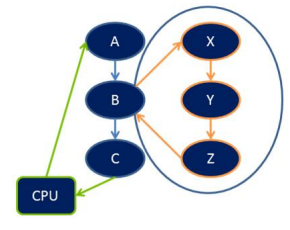

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-34aazuw_
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-34aazuw_
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 326b0a57a80c6d0b4bad25ca7adf8138419ef1cb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10741 sha256=1c43b610d84440f376c57bb0b3d20f87e2433fdb6f06eb98d5fd7c81c461a971
  Stored in directory: /tmp/pip-ephem-wheel-cache-2sr6v8ms/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpc4lglssl".


*The following basic example demonstrates the use of dynamic parallelism*

In [5]:
%%writefile cdp.cu
#include <stdio.h>
#include <stdlib.h>
#include <assert.h>
#include <cuda.h>
#define cucheck_dev(call)                                   \
{                                                           \
  cudaError_t cucheck_err = (call);                         \
  if(cucheck_err != cudaSuccess) {                          \
    const char *err_str = cudaGetErrorString(cucheck_err);  \
    printf("%s (%d): %s\n", __FILE__, __LINE__, err_str);   \
    assert(0);                                              \
  }                                                         \
}

__device__ int g_uids = 0;

__global__ void cdp_kernel(int max_depth, int depth, int thread, int parent_uid, int* output)
{
    // We create a unique ID per block. Thread 0 does that and shares the value with the other threads.
    __shared__ int s_uid;
    if (threadIdx.x == 0)
    {
      s_uid = atomicAdd(&g_uids, 1);
      output[0] = s_uid;
      printf("BLOCK %d launched by thread %d of block %d\n", s_uid, thread, parent_uid);
    }

    __syncthreads();

    // We launch new blocks if we haven't reached the max_depth yet.
    if (depth >= max_depth)
      return;

    cdp_kernel<<<gridDim.x, blockDim.x>>>(max_depth, depth+1, threadIdx.x, s_uid, output);
    cucheck_dev(cudaGetLastError());
    __syncthreads();
}

int main(int argc, char **argv)
{
    printf("starting Simple Print (CUDA Dynamic Parallelism)\n");

    // Parse a few command-line arguments.
    int max_depth = 3;

    // Print a message describing what the sample does.

    printf("The CPU launches 2 blocks of 2 threads each. On the device each thread will\n");
    printf("launch 2 blocks of 2 threads each. The GPU we will do that recursively\n");
    printf("until it reaches max_depth=%d\n\n", max_depth);
    printf("In total 2");
    int num_blocks = 2, sum = 2;

    for (int i = 1 ; i < max_depth ; ++i)
    {
        num_blocks *= 4;
        printf("+%d", num_blocks);
        sum += num_blocks;
    }

    printf("=%d blocks are launched!!! (%d from the GPU)\n", sum, sum-2);
    printf("***************************************************************************\n\n");
    // We set the recursion limit for CDP to max_depth.
    cudaDeviceSetLimit(cudaLimitDevRuntimeSyncDepth, max_depth);

    // Launch the kernel from the CPU.
    printf("Launching cdp_kernel() with CUDA Dynamic Parallelism:\n\n");
    int *output = (int *)malloc(sizeof(int)), *d_output;
    output[0] = 0;
    cudaMalloc((void **)&d_output, sizeof(int));
    cudaMemcpy(d_output, output, sizeof(int), cudaMemcpyHostToDevice);
    cdp_kernel<<<2, 2>>>(max_depth, 1, 0, -1, d_output);
    cudaMemcpy(output, d_output, sizeof(int), cudaMemcpyDeviceToHost);
    printf("Last block id = %d\n", output[0]);
    exit(EXIT_SUCCESS);
}

Writing cdp.cu


In [9]:
!nvcc cdp.cu -o cdp -rdc=true -lcudadevrt

In [10]:
!./cdp

starting Simple Print (CUDA Dynamic Parallelism)
The CPU launches 2 blocks of 2 threads each. On the device each thread will
launch 2 blocks of 2 threads each. The GPU we will do that recursively
until it reaches max_depth=3

In total 2+8+32=42 blocks are launched!!! (40 from the GPU)
***************************************************************************

Launching cdp_kernel() with CUDA Dynamic Parallelism:

BLOCK 1 launched by thread 0 of block -1
BLOCK 0 launched by thread 0 of block -1
BLOCK 2 launched by thread 0 of block 0
BLOCK 5 launched by thread 0 of block 1
BLOCK 3 launched by thread 0 of block 0
BLOCK 4 launched by thread 0 of block 1
BLOCK 9 launched by thread 0 of block 5
BLOCK 8 launched by thread 0 of block 5
BLOCK 6 launched by thread 0 of block 2
BLOCK 7 launched by thread 0 of block 2
BLOCK 10 launched by thread 0 of block 3
BLOCK 11 launched by thread 0 of block 3
BLOCK 13 launched by thread 0 of block 4
BLOCK 12 launched by thread 0 of block 4
BLOCK 14 launche

In [11]:
# Note: essential compilation flags for cdp
!nvcc cdp.cu -o cdp -rdc=true -lcudadevrt
!nvprof ./cdp

starting Simple Print (CUDA Dynamic Parallelism)
The CPU launches 2 blocks of 2 threads each. On the device each thread will
launch 2 blocks of 2 threads each. The GPU we will do that recursively
until it reaches max_depth=3

In total 2+8+32=42 blocks are launched!!! (40 from the GPU)
***************************************************************************

==4462== NVPROF is profiling process 4462, command: ./cdp
Launching cdp_kernel() with CUDA Dynamic Parallelism:

BLOCK 0 launched by thread 0 of block -1
BLOCK 1 launched by thread 0 of block -1
BLOCK 2 launched by thread 0 of block 1
BLOCK 4 launched by thread 0 of block 0
BLOCK 3 launched by thread 0 of block 1
BLOCK 5 launched by thread 0 of block 0
BLOCK 6 launched by thread 0 of block 2
BLOCK 7 launched by thread 0 of block 2
BLOCK 9 launched by thread 0 of block 4
BLOCK 8 launched by thread 0 of block 4
BLOCK 10 launched by thread 0 of block 3
BLOCK 11 launched by thread 0 of block 3
BLOCK 12 launched by thread 0 of block 5

### **Bonus Requirement**

Refer to Requirement 3 - Part A: Binary Search. Implement the same functionality using CDP

In [266]:
!nvcc k.cu -o k -rdc=true -lcudadevrt


k.cu(62): error: identifier "d_target" is undefined
          if (d_array[mid] == *d_target) {
                               ^

k.cu(64): error: identifier "d_target_index" is undefined
              *d_target_index = mid;
               ^

k.cu(67): error: expected a ";"
              return;
              ^

k.cu(80): error: identifier "d_target_index" is undefined
        *d_target_index = -1;
         ^

4 errors detected in the compilation of "k.cu".


In [267]:
!./k /content/input.txt 3.8

Hello World
1.200000
3.800000
6.400000
15.000000
20.000000
BLOCK 0 launched by thread 0 of block -1
grid_tid(0):[0,4]
grid_tid(1):[0,4]
N_range:5
N_range:5
N_thread_range:2
N_thread_range:2
0:[0-1]
1:[2-4]
BLOCK 1 launched by thread 0 of block 0
grid_tid(0):[0,1]
grid_tid(1):[0,1]
Max Depth Reached We need to apply Binary Search
Max Depth Reached We need to apply Binary Search
BLOCK 2 launched by thread 1 of block 0
grid_tid(0):[2,4]
grid_tid(1):[2,4]
Max Depth Reached We need to apply Binary Search
Max Depth Reached We need to apply Binary Search
0


### **Quick Tips**


*   Use nvprof --print-gpu-trace for a more detailed profiling result, including the start time and durations of every activity (should be helpful with streaming)
*   Use [cuda occupancy calculator](https://xmartlabs.github.io/cuda-calculator/) to check for the occupancy/utilization of the GPU for your running kernel



### **Resources**


*   https://developer.download.nvidia.com/assets/cuda/docs/TechBrief_Dynamic_Parallelism_in_CUDA_v2.pdf
*   https://developer.nvidia.com/blog/introduction-cuda-dynamic-parallelism/
*   https://github.com/zchee/cuda-sample/blob/master/0_Simple/cdpSimplePrint/cdpSimplePrint.cu
*   https://developer.nvidia.com/blog/cuda-pro-tip-nvprof-your-handy-universal-gpu-profiler/

